In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from ast import literal_eval 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import json
import scipy.stats as stats
import spacy
nlp = spacy.load("en_core_web_sm")


In [3]:
df = pd.read_csv('data\merged_file.csv',low_memory=False)
df= df.dropna(subset='PlotSummaries')

df_sum = df[['release_date','PlotSummaries']]
df_sum = df_sum[(df_sum['release_date'] >= 1910) & (df_sum['release_date'] <= 2013) ] 
display(df_sum.dropna(subset='release_date'))

,release_date,PlotSummaries
0,2007.0,"Three friends -– Arlene , Shanna , and radio D..."
1,2007.0,{{plot}} The movie opens with the first traile...
5,2007.0,Om Prakash Makhija is a junior artiste in the ...
6,2007.0,Shot in both Latin America and the United Stat...
9,2008.0,The film is presented as found footage from a...
...,...,...
88012,2010.0,"The film is about two friends, Tayyar , a mafi..."
88013,1941.0,{{plot}} The film opens with a Great Western e...
88015,2011.0,Two former National Oceanic Atmospheric Admini...
88017,1992.0,"The story takes place in the year 2092,The Sup..."


In [4]:
# Load spaCy model with disabled components for efficiency
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Pre-compile the list of stop words for faster checking
stop_words = nlp.Defaults.stop_words

# Function to check if token should be included
def is_token_allowed(token):
    return not token.is_punct and token.pos_ in ["ADJ", "PROPN"] and token.text.lower() not in stop_words

# Function to preprocess token
def preprocess_token(token):
    return token.lemma_.strip().lower()

def process_text(summary):
    # Ensure the text is treated as a writable string
    doc = nlp(summary)
    # Convert the processed tokens to strings to avoid any complex types
    return [preprocess_token(token) for token in doc if is_token_allowed(token)]

# 10 mins        
df_sum['tokens']= df_sum['PlotSummaries'].apply(lambda x: process_text(x))



In [5]:
display(df_sum)

,release_date,PlotSummaries,tokens
0,2007.0,"Three friends -– Arlene , Shanna , and radio D...","[arlene, shanna, dj, jungle, julia, lucai, con..."
1,2007.0,{{plot}} The movie opens with the first traile...,"[machete, rural, texas, cherry, darling, numer..."
5,2007.0,Om Prakash Makhija is a junior artiste in the ...,"[om, prakash, makhija, junior, pappu, om, bela..."
6,2007.0,Shot in both Latin America and the United Stat...,"[latin, america, united, states, historic, cur..."
9,2008.0,The film is presented as found footage from a...,"[personal, united, states, department, defense..."
...,...,...,...
88012,2010.0,"The film is about two friends, Tayyar , a mafi...","[tayyar, davut, eşrefpaşa, istanbul, eleni, da..."
88013,1941.0,{{plot}} The film opens with a Great Western e...,"[great, western, box, tunnel, cornwall, herber..."
88015,2011.0,Two former National Oceanic Atmospheric Admini...,"[national, oceanic, atmospheric, administratio..."
88017,1992.0,"The story takes place in the year 2092,The Sup...","[super, dimension, fortress, macross, ii, orig..."


The way we looked at the representation of different ethnicities or demographic groups through time is by identifying ethnicity related words in the movie summaries. We decided to include locations as well since in the case of nationality, location play a great role in representation of a group. This method of search for representation is partially flawed because all summaries do not precise the location or ethnicity of their characters, which reduces greatly our sample size. Moreover, the way the words are counted favors historical films which may have a lot more nationality related words in their summary, even when other film are taking place in historically relevant places but are not historical.

In [8]:
data = {
    "Ethnicity": [
        "French", "German", "Italian", "Spanish", "Chinese", "Japanese", "Indian", 
        "Russian", "Mexican", "Brazilian", "Canadian", "Australian", "African", 
        "Middle Eastern", "Scandinavian", "American", 'English', 'Vietnamese', 
        'Afghan', 'Ukrainian', 'Thai', 'Malaysian','Soviet','Iranian','Austrian',
        'Hungarian','Turkish',"Allied Forces","Allies","Central Powers","Axis"
    ],
    "Keywords": [
        ["french", "france", "paris", "lyon", "marseille", "alsace", "provence", "normandy", "verdun", "vichy"],
        ["german", "germany", "berlin", "bavarian", "frankfurt", "blackforest", "ruhr", "stalingrad", "dresden", "berlinwall"],
        ["italian", "italy", "rome", "venetian", "tuscany", "sicily", "naples"],
        ["spanish", "spain", "madrid", "barcelona", "andalusia", "catalonia", "basque"],
        ["chinese", "china", "beijing", "shanghai", "hongkong", "tibet", "xinjiang"],
        ["japanese", "japan", "tokyo", "osaka", "kyoto", "hokkaido", "okinawa", "hiroshima", "nagasaki"],
        ["indian", "india", "delhi", "mumbai", "rajasthan", "kerala", "punjab"],
        ["russian", "russia", "moscow", "stpetersburg", "siberia", "ural", "volga", "stalingrad", "leningrad"],
        ["mexican", "mexico", "mexico city", "guadalajara", "yucatan", "oaxaca", "chiapas"],
        ["brazilian", "brazil", "rio", "saopaulo", "amazon", "pantanal"],
        ["canadian", "canada", "toronto", "vancouver", "quebec", "alberta", "ontario", "vimyridge"],
        ["australian", "australia", "sydney", "melbourne", "greatbarrierreef", "outback", "tasmania"],
        ["african", "africa", "nigerian",'niger', "kenyan",'kenya', "southafrica", "egypt","egyptian", "morocco",'moroccan', "northafrica"],
        ["middleeastern", "middleeast", "arab", "israeli", "dubai", "mesopotamia", 'iraq','iraqi','israel','kuwait','saudi','arabia','levant'],
        ["scandinavian", "scandinavia", "swedish", "norwegian", "lapland", "fjords", "gotland"],
        ["american", "newyork", "losangeles", "chicago"],
        ["british", 'london', 'manchester', 'birmingham', 'scotland', 'wales', 'northernireland', "falklands"],
        ["viet",'vietnamese', 'vietnam', 'hanoi', 'saigon', 'mekongdelta', 'halongbay', 'hue' ],
        ["afghanistan", 'kabul', 'herat', 'kandahar', 'hindukush', 'balkh', 'helmand','afghan'],
        ['ukrainian', 'ukraine', 'kiev', 'kharkiv', 'lviv', 'donbas', 'crimea'],
        ['thai', 'thailand', 'bangkok', 'chiangmai', 'phuket', 'isaan', 'krabi'],
        ['malaysian', 'malaysia', 'kualalumpur', 'penang', 'borneo', 'langkawi', 'melaka'],
        ['soviet','ussr','sovietic'],
        ['iranian','iran'],
        ["austrian", "austria", "vienna", "salzburg", "innsbruck", "graz"],
        ["hungarian", "hungary", "budapest", "debrecen"],
        ["turkish", "turkey", "istanbul", "ankara", "izmir", "antalya", "cappadocia", "bosphorus"],
        ["french", "france", "paris", "lyon", "marseille", "alsace", "provence", "normandy", "verdun", "vichy",
        "british", 'london', 'manchester', 'birmingham', 'scotland', 'wales', 'northernireland', "falklands",
        "russian", "russia", "moscow", "stpetersburg", "siberia", "ural", "volga", "stalingrad", "leningrad",
        "japanese", "japan", "tokyo", "osaka", "kyoto", "hokkaido", "okinawa", "hiroshima", "nagasaki"],
        ["french", "france", "paris", "lyon", "marseille", "alsace", "provence", "normandy", "verdun", "vichy",
        "poland","polish", 
        "british", 'london', 'manchester', 'birmingham', 'scotland', 'wales', 'northernireland', "falklands"],
        ["russian", "russia", "moscow", "stpetersburg", "siberia", "ural", "volga", "stalingrad", "leningrad",
        "japanese", "japan", "tokyo", "osaka", "kyoto", "hokkaido", "okinawa", "hiroshima", "nagasaki"],
        [],
    ]
}

eth = pd.DataFrame(data)
eth['Keywords'] = eth['Keywords'].apply(str)
eth['Ethnicity'] = eth['Ethnicity'].apply(str)

data = {
    'Ethnicity': ['Nazi','Jewish','Islamic','LGBTQ','Man','Woman','Boy','Girl','Elderly'],
    'Keywords': [
        ['nazi', 'nazis'],
        ['jewish', 'jews','jew','ashkenazy'],
        ['islamic', 'muslim', 'islam','muslims'],
        ['pansexual', 'homo', 'homosexual', 'queer', 'gay', 'lesbian', 'bisexual', 'transgender','lgbtq'],
        ['man','men'],
        ['woman','women'],
        ['boy'],
        ['girl'],
        ['old','elderly','grandma','grandpa']
    ]
}

eth2 = pd.DataFrame(data)
eth2['Keywords'] = eth2['Keywords'].apply(str)
eth2['Ethnicity'] = eth2['Ethnicity'].apply(str)
ethmerged= pd.concat([eth,eth2],ignore_index=True)

ethmerged.head()



,Ethnicity,Keywords
0,French,"['french', 'france', 'paris', 'lyon', 'marseil..."
1,German,"['german', 'germany', 'berlin', 'bavarian', 'f..."
2,Italian,"['italian', 'italy', 'rome', 'venetian', 'tusc..."
3,Spanish,"['spanish', 'spain', 'madrid', 'barcelona', 'a..."
4,Chinese,"['chinese', 'china', 'beijing', 'shanghai', 'h..."


In [42]:
def get_count_per_year(df,eth):
    data = df.copy()

    ethnicities = eth['Ethnicity']
   
    for et in ethnicities:
        # Find the index of the ethnicity in the 'eth' DataFrame
        index = eth[eth['Ethnicity'] == et].index[0]
        # Extract the list of keywords related to the ethnicity
        occ_list = literal_eval(eth.at[index, 'Keywords'])

        # Define a function to count the occurrences of ethnicity-related words in a list
        def count_words(word_list):
            return sum(word.lower() in occ_list for word in word_list)

        data[et] = data['tokens'].apply(lambda x: count_words(x))

    # optionnal groupment per period
    period = 1
    data['release_period'] = data['release_date'] // period * period

    counts_by_period = data.groupby('release_period')[ethnicities].sum().reset_index()

    total_words_by_period = data.groupby('release_period')['tokens'].apply(
        lambda x: sum(len(word_list) for word_list in x)
    ).reset_index()

    all_counts_by_period = pd.merge(counts_by_period, total_words_by_period, on='release_period', how='left')
    return all_counts_by_period
    
all_counts_by_period = get_count_per_year(df_sum,ethmerged)
    

In [44]:
all_counts_by_period.head()

,release_period,French,German,Italian,Spanish,Chinese,Japanese,Indian,Russian,Mexican,...,Nazi,Jewish,Islamic,LGBTQ,Man,Woman,Boy,Girl,Elderly,tokens
0,1910.0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,1,0,0,0,1,239
1,1911.0,1,0,3,0,0,0,2,0,0,...,0,3,0,0,2,0,0,0,6,1007
2,1912.0,2,0,0,0,0,0,2,0,0,...,0,0,0,0,1,0,0,1,10,573
3,1913.0,1,1,0,3,1,0,2,1,0,...,0,1,0,0,0,0,0,0,3,809
4,1914.0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,8,737


In [9]:
def plot_occurrences(all_counts_by_period, ethnicities, highlight_periods=None, period=1):

    cols = ['release_period','tokens']+ ethnicities

    counts_by_period = all_counts_by_period[cols].copy()
   
    counts_by_period_long = pd.melt(counts_by_period, id_vars='release_period', value_vars=ethnicities)

    
    fig = go.Figure()

    # Create a line plot for each ethnicity
    for et in ethnicities:
        fig.add_trace(go.Scatter(
            x=counts_by_period_long['release_period'],
            y=counts_by_period_long['value'][counts_by_period_long['variable'] == et],
            mode='lines',
            name=et
        ))

    # Add highlighted periods to the plot, if specified
    if highlight_periods:
        for period_range in highlight_periods:
            fig.add_vrect(
                x0=period_range[0],
                x1=period_range[1],
                annotation_text=period_range[2],
                annotation_position="top left",
                fillcolor='rgba(255, 0, 0, 0.20)', 
                layer='below',
                line_width=1
            )

    # Update layout
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Group-related Word count',
        legend_title='Ethnicity',
        template='seaborn'
    )

    return fig


In [72]:
def plot_relative_occurrences(all_counts_by_period, ethnicities, highlight_periods=None, rolling=5,):


    cols = ['release_period','tokens']+ ethnicities

    counts_by_period = all_counts_by_period[cols].copy()
    

    # Normalize the counts by the total number of words and apply a rolling average
    for et in ethnicities:
        counts_by_period[et] = counts_by_period[et] / counts_by_period['tokens']
        counts_by_period[et] = counts_by_period[et].rolling(window=rolling).mean()

    counts_by_period_long = pd.melt(counts_by_period, id_vars='release_period', value_vars=ethnicities)
    
    counts_by_period_z = counts_by_period.copy()
    for et in ethnicities:
        counts_by_period_z[et] = (counts_by_period[et] - counts_by_period[et].mean()) / counts_by_period[et].std()

    

    fig = go.Figure()

    # Create a line plot using Plotly Go
    for et in ethnicities:
        
        fig.add_trace(go.Scatter(
            x=counts_by_period_long['release_period'],
            y=counts_by_period_long['value'][counts_by_period_long['variable'] == et] * 100,
            mode='lines',
            name=et,
            text = counts_by_period_z[et]
        ))

    # Add highlighted periods to the plot, if specified
    if highlight_periods:
        for period_range in highlight_periods:
            fig.add_vrect(
                x0=period_range[0],
                x1=period_range[1],
                annotation_text=period_range[2],
                annotation_position="top left",
                fillcolor='rgba(255, 0, 0, 0.20)', 
                layer='below',
                line_width=1
            )


    # Update layout
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Relative Word Occurrence %',
        legend_title='Demographic Group',
        template='seaborn'
    )
    
    return fig
ethnicities=['Spanish','Italian','Austrian']
plot_relative_occurrences(all_counts_by_period, ethnicities)


In [67]:
def plot_relative_occurrences_mean(all_counts_by_period, ethnicities, highlight_periods=None, average=5):

    cols = ['release_period', 'tokens'] + [item for sublist in ethnicities for item in sublist]

    counts_by_period = all_counts_by_period[cols].copy()

    # Normalize the counts by the total number of words and apply a rolling average
    group_list = []
    for list in ethnicities:
        group = '-'.join(list) + ' mean'
        group_list.append(group)
        group_total = sum(counts_by_period[et] for et in list)
        counts_by_period[group] = group_total / counts_by_period['tokens']
        counts_by_period[group] = counts_by_period[group].rolling(window=average).mean()

    counts_by_period_long = pd.melt(counts_by_period, id_vars='release_period', value_vars=group_list)

    counts_by_period_z = counts_by_period.copy()
    for group in group_list:
        group_mean = counts_by_period[group].mean()
        group_std = counts_by_period[group].std()
        counts_by_period_z[group] = (counts_by_period[group] - group_mean) / group_std

    fig = go.Figure()

    # Create a line plot using Plotly Go
    for group in group_list:
        fig.add_trace(go.Scatter(
            x=counts_by_period_long['release_period'],
            y=counts_by_period_long['value'][counts_by_period_long['variable'] == group] * 100,
            mode='lines',
            name=group,
            text=counts_by_period_z[group]
            ))

    # Add highlighted periods to the plot, if specified
    if highlight_periods:
        for period_range in highlight_periods:
            fig.add_vrect(
                x0=period_range[0],
                x1=period_range[1],
                annotation_text=period_range[2],
                annotation_position="top left",
                fillcolor='rgba(255, 0, 0, 0.20)',
                layer='below',
                line_width=1
            )

    # Update layout
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Relative Word Occurrence %',
        legend_title='Demographic Group',
        template='seaborn'
    )

    return fig


In [12]:
def plot_box(df, eth, ethnicities, highlight_periods=None, average=5,zscore=False):

    data = df.copy()


    for et in ethnicities:
        # Find the index of the ethnicity in the 'eth' DataFrame
        index = eth[eth['Ethnicity'] == et].index[0]
        # Extract the list of keywords related to the ethnicity
        occ_list = literal_eval(eth.at[index, 'Keywords'])

        # Define a function to count the occurrences of ethnicity-related words in a list
        def count_words(word_list):
            return sum(word.lower() in occ_list for word in word_list)

        data[et] = data['tokens'].apply(lambda x: count_words(x))

    # Group by release year and sum the counts
    period = 1
    data['release_period'] = data['release_date'] // period * period
    counts_by_period = data.groupby('release_period')[ethnicities].sum().reset_index()

    
    total_words_by_period = data.groupby('release_period')['tokens'].apply(
        lambda x: sum(len(word_list) for word_list in x)
    ).reset_index()

    counts_by_period = pd.merge(counts_by_period, total_words_by_period, on='release_period', how='left')

    # Normalize the counts by the total number of words and apply a rolling average
    for et in ethnicities:
        counts_by_period[et] = counts_by_period[et] / counts_by_period['tokens']
        counts_by_period[et] = counts_by_period[et].rolling(window=average).mean()
        

    counts_by_period_long = pd.melt(counts_by_period, id_vars='release_period', value_vars=ethnicities)

    

    fig = px.box(counts_by_period_long,y='value', color='variable',
                 title='Relative Occurrences of Ethnicity-related Words Over {} Years'.format(period),
                 labels={'value': 'Relative Word Occurrence %','release_period':'Year' ,'variable': 'Ethnicity'},
                 category_orders={'variable': ethnicities},
                 template='seaborn'
        )

    return fig
ethnicities=['Spanish','Italian','Austrian']
plot_box(df_sum, ethmerged, ethnicities)



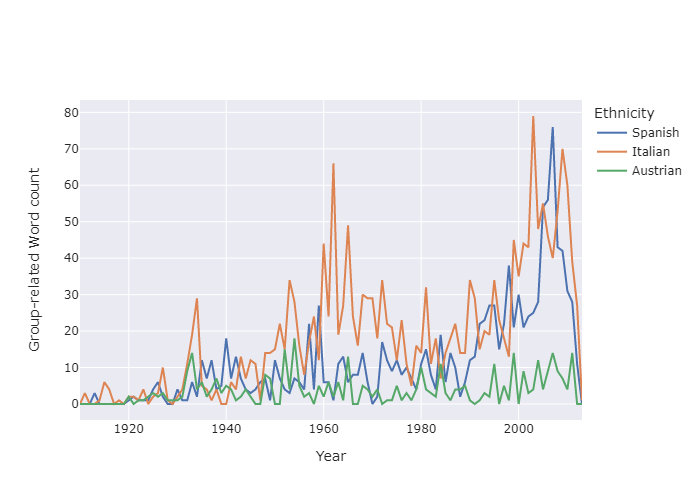

In [14]:
ethnicities=['Spanish','Italian','Austrian']
fig = plot_occurrences(all_counts_by_period, ethnicities)

fig.show(renderer="png")
fig_json = fig.to_json()

#with open('figures/ethnicity-representation0.json', 'w') as json_file:
#   json.dump(json.loads(fig_json), json_file, indent=4)


In [50]:
ethnicities=['Spanish','Italian','Austrian']
fig = plot_relative_occurrences(all_counts_by_period, ethnicities)

fig.show()

fig_json = fig.to_json()
#with open('figures/ethnicity-representation1.json', 'w') as json_file:
#    json.dump(json.loads(fig_json), json_file, indent=4)



### World War I and World War II ###

We choose to group the occurrences of word by 5 years sinc the year by year data is high variance.

In [29]:
ethnicities=['German','Nazi','Japanese','Russian','Soviet','American','Italian','Austrian','English', "Mexican", "Brazilian", "Canadian",'Australian']
fig = plot_relative_occurrences(all_counts_by_period, ethnicities,[
    ('1914', '1918', 'WWI'),
    ('1939', '1945', 'WWII'),
    ('1989', '1989', 'Fall of the Berlin Wall')
])
fig.show()

#fig_json = fig.to_json()

#with open('figures/ethnicity-representation2.json', 'w') as json_file:
#   json.dump(json.loads(fig_json), json_file, indent=4)


In [17]:
ethnicities=['French','Spanish','American','English']
fig = plot_relative_occurrences(all_counts_by_period, ethnicities,[
    ('1914', '1918', 'WWI'),
    ('1939', '1945', 'WWII'),
    ('1989', '1989', 'Fall of the Berlin Wall')
])
fig.show()
fig_json = fig.to_json()

#with open('figures/ethnicity-representation3.json', 'w') as json_file:
#   json.dump(json.loads(fig_json), json_file, indent=4)

#### Cold War ####

In [18]:
ethnicities=['Russian','Scandinavian','Soviet']
fig=plot_relative_occurrences(all_counts_by_period, ethnicities,[
    ('1947', '1991', 'Cold War'),('1922','1922','Start of USSR')
])
fig.show()
fig_json = fig.to_json()

#with open('figures/ethnicity-representation4.json', 'w') as json_file:
#   json.dump(json.loads(fig_json), json_file, indent=4)

The cold war period seems to have a delayed increase in representation after 1960, which sustains itself through the conflict. While Russian representation keeps rising afterward, the comparison with a few east european countries suggest that this is not only due to the rise of total number of films. 

#### Vietnam War ####


In [19]:
ethnicities=['Vietnamese','Thai','Malaysian']
fig = plot_relative_occurrences(all_counts_by_period, ethnicities,[
    ('1955', '1975', 'Vietnam War')
])
fig.show()

fig_json = fig.to_json()

#with open('figures/ethnicity-representation5.json', 'w') as json_file:
#    json.dump(json.loads(fig_json), json_file, indent=4)

The Vietnam war display similar behavior to the cold war but we can observe a decrease in representation after some time, the War in Afghanistan seem to display an surge of interest as well. The data does not stop abruptly in the dataset, so the last years having few representations is mainly due to lack of data.

In [20]:
ethnicities=['Afghan','Iranian']
fig = plot_relative_occurrences(all_counts_by_period, ethnicities,[
    ('2001', '2021', 'Afghanistan War')
])
fig.show()

fig_json = fig.to_json()

with open('figures/ethnicity-representation6.json', 'w') as json_file:
    json.dump(json.loads(fig_json), json_file, indent=4)

In [21]:
ethnicities=["Middle Eastern",'Islamic','African']
plot_relative_occurrences(all_counts_by_period, ethnicities, [('2001', '2001', '9/11 Attacks')]).show()

This is similar to what we saw for other events.

We choose to focus on historical event involving the USA because for the time period of our dataset, the USA were the main producers of movies. Indeed, it seems like big events for other countries do not create the same reaction spike, like this example.

Overall, we would like to dive deeper into the increase of representation after a big event as well as the first spike in popularity.

In [79]:
def plot_relative_centered(all_counts_by_period, ethnicities, period=5, highlight_periods=None):
    cols = ['release_period','tokens']+ ethnicities

    counts_by_period = all_counts_by_period[cols].copy()

    for et in ethnicities:
        counts_by_period[et] = counts_by_period[et] / counts_by_period['tokens']

    # Convert the DataFrame to long format for Plotly
    counts_by_period_long = pd.melt(counts_by_period, id_vars='release_period', value_vars=ethnicities)

    # Create a stacked area plot using Plotly Express
    fig = px.area(counts_by_period_long, x='release_period', y='value', color='variable',
                 title='Relative Occurrences of Ethnicity-related Words Over the Years',
                 labels={'value': 'Relative Occurrences', 'variable': 'Ethnicity'},
                 category_orders={'variable': ethnicities})

    if highlight_periods:
        for period_range in highlight_periods:
            fig.add_vrect(
                x0=period_range[0],
                x1=period_range[1],
                annotation_text=period_range[2],
                annotation_position="top left",
                fillcolor='rgba(255, 0, 0, 0.3)', 
                layer='below',
                line_width=1)
    fig.update_xaxes(range=[int(period_range[0])-20, int(period_range[0])+40])
    return fig


In [85]:

figures = [
plot_relative_occurrences(all_counts_by_period, ['German','Nazi','Japanese',]),
plot_relative_occurrences(all_counts_by_period, ['French','Spanish','American'])   
]
dates_list= [
    [('1914', '1918', 'WWI'),
    ('1939', '1945', 'WWII'),
    ('1989', '1989', 'Fall of the Berlin Wall')],
    [],
    []
             ]
fig = make_subplots(rows=len(figures), cols=1) 

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=i+1, col=1)
    for date in dates_list[i]:    
        fig.add_vrect(
                x0=date[0],
                x1=date[1],
                annotation_text=date[2],
                annotation_position="top left",
                fillcolor='rgba(255, 0, 0, 0.2)', 
                layer='below',
                line_width=1, row=i+1, col=1)


fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Relative Word Occurrence %',
        legend_title='Demographic Group',
        template='seaborn'
    )

#fig_json = fig.to_json()

#with open('figures/ethnicity-representation.json', 'w') as json_file:
#    json.dump(json.loads(fig_json), json_file, indent=4)   

fig.show()